# Shea Ackers Modeling of Gal4
In this notebook we will parameterize a fast shea ackers model and apply it to Gal4. An earlier version of this model used Matlab for the dynamic programming, and some of the front end scripts are written in such a way as to maintain compatibity. 

We first need to make two text files: an epsilon matrix, which is just the free energies of binding for each site for each promoter, and a hops.txt (or TPH.txt) file.  Each row of the hops.txt file gives the experimentally observed binding score (in units of TPH, or transpositions per promoter normalized to 100,000 total insertions collected). These files have to have the same ordering -- the ith row in each should correspond to the same promoter in yeast. 

##  Translating from a PWM to a Free Energy Matrix
The ScerTF database contains position specific weight matrices (PWMs) for nearly all TFs in yeast.  How can one translate from a PWM to a free energy matrix, which is required for the Shea Ackers model?  There are several treatments of this.  We use the approach described in "Neural networks for determining protein specificity and multiple alignment of binding sites" by Heumann, Lapedes and Stormo 1994.  

They derive the following relationship between a free energy matrix and the frequency matrix (equation 19 in the paper):

$$W(b,m) = -ln \frac{F(b,m)}{p(b)} $$

Since a PWM has the equation:
$$PWM(b,m) = log_2\frac{F(b,m)}{p(b)}$$

These can be converted by:
$$W(b,m) = -ln(2)*PWM(b,m)$$

However, we obtained PWMs from the ScerTF database, which converted the PFM to PWM using the non-conventional formula, 

$$PWM_{Spivak}(b,m) = ln \frac{F(b,m)}{p(b)}$$

where $p(b) =$ {"A":0.32,"C":0.18,"G":0.18,"T":0.32} instead of the usual $p(b)=$ {"A":0.31,"C":0.19,"G":0.19,"T":0.31}

So, to convert a Spivak PWM to a free energy matrix, ignoring the slight differences in the background distributions $p(b)$, one simply does the following:

$$W(b,m) = -PWM_{Spivak}(b,m)$$

In [106]:
from analyze_sig_hits_v3 import *

In [108]:
#Load experimental Gal4 data
cf = make_comparison_frame('./sig_prom_gal4_FL_combined.gnashy.txt',
                           './sig_prom_gal4_DBD_combined.gnashy.txt'
                           ,'Gal4_FL','Gal4_DBD',True,True)

In [109]:
cf.head()

,Gal4_FL TPH BS,Gal4_FL pvalue,Gal4_DBD TPH BS,Gal4_DBD pvalue,Sequence,Log2FC,Left Common Name,Right Common Name
Intergenic Region,,,,,,,,
Chr12: 289251-290213,5223.260730,0.0,3177.730496,0.000000e+00,"(T, G, C, C, A, A, G, C, T, G, T, A, T, G, G, ...",-0.716954,EMP46,GAL2
Chr2: 275527-276253,4150.400945,0.0,4726.492493,0.000000e+00,"(C, A, T, A, C, A, A, T, G, G, A, G, C, T, G, ...",0.187519,GAL7,GAL10
Chr11: 613527-615372,3173.825349,0.0,292.733355,0.000000e+00,"(C, G, C, C, G, C, T, A, G, A, A, C, T, G, G, ...",-3.438564,SRP40,PTR2
Chr11: 229524-231871,2484.335559,0.0,0.000000,7.709607e-01,"(T, T, A, T, G, C, C, T, A, A, A, G, A, T, T, ...",-11.278644,KTI12,HAP4
Chr4: 1488983-1490589,2469.753335,0.0,171.753097,2.152167e-12,"(T, A, C, A, T, C, G, A, A, G, A, G, A, T, T, ...",-3.845959,AGE1,SNA2


# Making an Epsilon File for Shea-Ackers in matlab
In principle, we could compute the free energy of binding for every base pair in all bound and/or unbound promoters. However, for Gal4, we can use a cutoff to only consider binding at sites with at least a modest affinity to the TF, since very weak sites will not contribute to the computation, and the code will run much faster this way. We used a PWM/Free Energy cutoff of 8, which excludes sites 256 fold weaker than the consensus site. Our analysis is insensitive to the value of this cutoff. Also, for backwards compatibility with our Matlab code for computing Shea Ackers, the matrix is made square by adding 999's (which are ignored) to account for the different promoter lengths and pass along a square matrix for dynamic programming. So the procedure is 1) Apply cutoff to ignore very weak sites. 2) Convert PWM scores to free energy scores. 3) Square the matrix by adding 999's to the end of the lists of scores. 4) Print the matrix to a file.  In this section, we compute the free energies for all promoters bound by Gal4 in order to quantitatively predict the binding of Gal4 at each target. The free energies are put into a annotated dataframe and then saved to a text file, "epsilon_gal4_all.txt"

In [110]:
#Read in binding data and identify promoters bound by Gal4 in order to predict the quantitative amount of binding at this set of promoters

gal4_bound = cf[cf["Gal4_FL pvalue"]<1.1e-5]

In [111]:
len(gal4_bound)

82

In [112]:
#gal4_for_epsilon will contain the free energy information

gal4_for_epsilon = gal4_bound.copy()

In [113]:
gal4_for_epsilon = add_pwm_info(gal4_for_epsilon,'gal4',8)

In [114]:
gal4_for_epsilon.head()

,Gal4_FL TPH BS,Gal4_FL pvalue,Gal4_DBD TPH BS,Gal4_DBD pvalue,Sequence,Log2FC,Left Common Name,Right Common Name,gal4 pos,gal4 score,gal4 orientaion
Intergenic Region,,,,,,,,,,,
Chr12: 289251-290213,5223.260730,0.0,3177.730496,0.000000e+00,"(T, G, C, C, A, A, G, C, T, G, T, A, T, G, G, ...",-0.716954,EMP46,GAL2,"[599, 713, 716, 796]","[9.97, 12.27, 11.639999999999997, 16.119999999...","[-1, -1, 1, -1]"
Chr2: 275527-276253,4150.400945,0.0,4726.492493,0.000000e+00,"(C, A, T, A, C, A, A, T, G, G, A, G, C, T, G, ...",0.187519,GAL7,GAL10,"[327, 414]","[13.490000000000002, 12.719999999999999]","[1, 1]"
Chr11: 613527-615372,3173.825349,0.0,292.733355,0.000000e+00,"(C, G, C, C, G, C, T, A, G, A, A, C, T, G, G, ...",-3.438564,SRP40,PTR2,[],[],[]
Chr11: 229524-231871,2484.335559,0.0,0.000000,7.709607e-01,"(T, T, A, T, G, C, C, T, A, A, A, G, A, T, T, ...",-11.278644,KTI12,HAP4,[],[],[]
Chr4: 1488983-1490589,2469.753335,0.0,171.753097,2.152167e-12,"(T, A, C, A, T, C, G, A, A, G, A, G, A, T, T, ...",-3.845959,AGE1,SNA2,[],[],[]


In [115]:
def compute_distance(x):
    if x:
        return x[-1] - x[0]
    else:
        return 0

In [116]:
gal4_for_epsilon["site_distance"]=gal4_for_epsilon["gal4 pos"].apply(lambda x: compute_distance(x))

In [117]:
gal4_for_epsilon["num_sites"]=gal4_for_epsilon["gal4 pos"].apply(lambda x: len(x)) #all gal4 bound promoters excluding indirect interactions

In [118]:
gal4_for_epsilon_all = gal4_for_epsilon.copy()  #all gal4 bound promoters

In [119]:
len(gal4_for_epsilon)

82

In [120]:
site_num = gal4_for_epsilon_all["num_sites"].tolist()

In [121]:
epsilon_series_all = gal4_for_epsilon_all["gal4 score"].apply(lambda x: [y*-1 for y in x])

In [122]:
epsilon_series_all.head()

Intergenic Region
Chr12: 289251-290213     [-9.97, -12.27, -11.639999999999997, -16.11999...
Chr2: 275527-276253             [-13.490000000000002, -12.719999999999999]
Chr11: 613527-615372                                                    []
Chr11: 229524-231871                                                    []
Chr4: 1488983-1490589                                                   []
Name: gal4 score, dtype: object

In [123]:

max_sites_all = max(epsilon_series_all.apply(len))


epsilon_series_all = epsilon_series_all.apply(lambda x: x+[999]*(max_sites_all-len(x)))



In [124]:
len(epsilon_series_all)

82

In [125]:

f1=open('./epsilon_gal4_all.txt', 'w+')

for line in epsilon_series_all:
    print("\t".join(map(str,line)), file=f1)

f1.close()

## Running the Shea Ackers Model
Most of what we've done so far is just load the data into a format we can manipulate readily.  Now we will keep only what columns we need and run the Shea Ackers Model. This model takes as input the free energy matrix for all Gal4p targets, the Gal4 concentration, and the free energy contribution of the cooperative contribution.  We used a Gal4 concentration of 27.5 nM based on the data in Ghaemmaghami et al (Nature 2003), who measured 166 Gal4 molecules / cell.  From this value, we computed a nuclear Gal4 concentration of 27.5 nM.  The cooperativity term was fit, but the model is relatively insensitive to both the energetic contribution of the cooperativity term and TF concentration.

In [126]:

hops_all = gal4_for_epsilon_all["Gal4_FL TPH BS"]

#This frame has the experimentally measured binding data at Gal4 targets

In [127]:
f1=open('./TPHBS_gal4_all.txt', 'w+')

for line in hops_all:
    print(line,file=f1)

f1.close()

In [128]:
run thermo4

In [129]:
epsilon = pd.read_csv("epsilon_gal4_all.txt",sep="\t",header=None)

In [130]:
hops = pd.read_csv("TPHBS_gal4_all.txt",sep="\t",header=None)

Correlation = 0.73


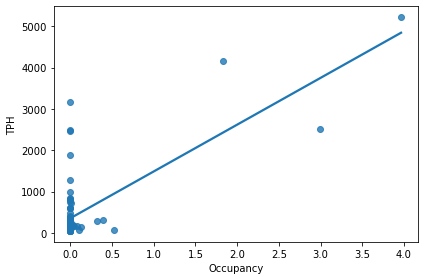

In [131]:
outframe_coop = fast_shea_ackers_series(epsilon,hops,1,-11,0.0000000275)

In [132]:
sns.reset_orig()

In [133]:
run ./gal4_scatterplot.py

In [134]:
outframe_coop.columns = ["Predicted Occupancy","Observed Binding (TPH)"]

0.7280109889280518
(0.7301715859952924, 7.049596465257269e-15)


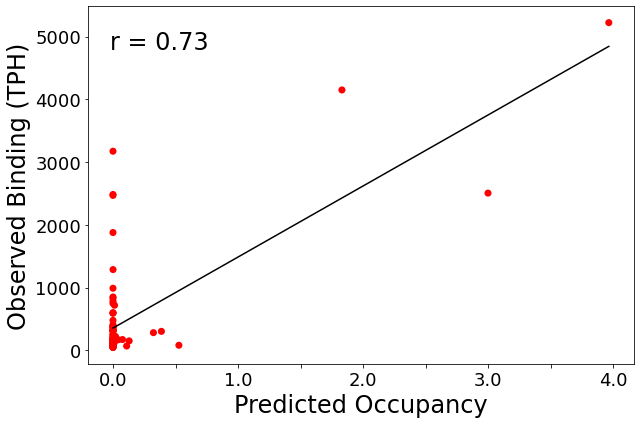

In [135]:
scatterplot_cc(outframe_coop,"Predicted Occupancy","Observed Binding (TPH)")

## Highlight promoters with and without a Gal4p site 
Red dots represent promoters with a Gal4p site while purple are promoters without a site

In [136]:
def scatterplot_cc_site(plot_frame, plot_frame2, xname = "X",yname = "Y"):
    from matplotlib import rcParams
    rcParams.update({'figure.autolayout':True})
    fig = plt.figure(figsize = (9,6))
    ax1 = fig.add_subplot(111)
    #plt.tight_layout
    #define experimental hop cutoff

    props = dict(alpha=1, edgecolors='none' )
    #find line of best fit
    xd = plot_frame[xname]
    yd = plot_frame[yname]
    par = np.polyfit(xd, yd, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]
    variance = np.var(yd)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    R = np.sqrt(Rsqr)
    print(R)
    R_test =scipy.stats.pearsonr(xd,yd)
    print(R_test)
    plt.text(.13,.9,'r = %0.2f'% R, fontsize=24,ha="center",va="center",transform=ax1.transAxes)
    handles = []
    
    #c = ["b" if y > 5 else "r" for y in y]
    
#     plot_frame.plot.scatter(x = 'xname', 
#                    y = 'yname', 
    c = ['red' if x else 'darkmagenta' for x in (plot_frame.sites > 0)] #,
#                    ax = ax1
#                   )


    handles.append(ax1.scatter(plot_frame[xname], plot_frame[yname], c=c, s=50, marker='o', **props))
    handles.append(ax1.plot(xl, yl, '-k'))
    #handles.append(ax1.scatter(plot_frame2.Occupancy, plot_frame2.TPH, color="orange"))



    #ax1.set_ylim([0,3500])
    #ax1.set_xlim([0,3000])
    ax1.grid(False)
    for item in ([ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() +ax1.get_yticklabels()):
        item.set_fontsize(18)
    for label in ax1.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    #ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlabel("Observed Binding (TPH)",fontsize=24)
    ax1.set_ylabel("Predicted Occupancy",fontsize=24)
    
    

# loop through to annotate multiple datapoints
#     for i in range(plot_frame2.shape[0]):
#         plt.annotate(plot_frame2.names.tolist()[i], (df_strong_gal.Predicted_Occupancy.tolist()[i], df_strong_gal.Observed_Binding_TPH.tolist()[i]))
#     print(df_strong_gal.shape[0])
    plt.tight_layout()


    #plt.show()
    plt.savefig("Shea_Ackers_gal4_final.pdf")

In [137]:
df = outframe_coop.loc[[5]]

In [138]:
outframe_coop["sites"] = site_num

In [139]:
df2 = outframe_coop.query('sites > 0')
combined_gal = pd.concat([df2, df])

In [140]:
combined_gal = combined_gal.dropna()

0.7280109889280518
(0.7301715859952924, 7.049596465257269e-15)


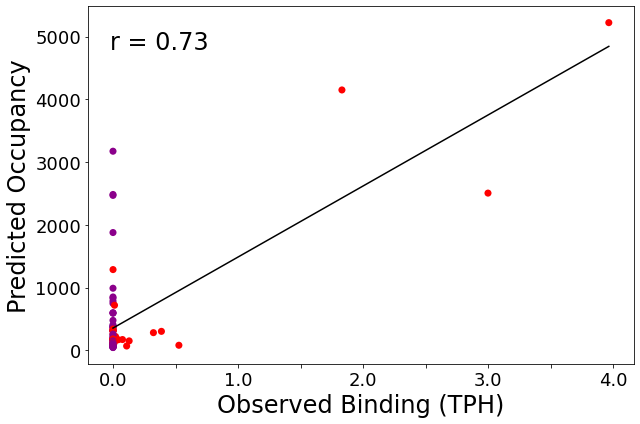

In [142]:
scatterplot_cc_site(outframe_coop, combined_gal,"Predicted Occupancy", "Observed Binding (TPH)")